In [3]:
# %load ~/ipyhead
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

def savefig(fig, *args, **kwargs):
    if 'bbox_inches' not in kwargs:
        kwargs['bbox_inches'] = 'tight'
    fig.savefig(*args, **kwargs)

# Hierarchical classification (HC)

We have a label/class hierarchy: e.g. B cells --> B cells naive.

We've seen that B cells naive and B cells memory are hard to differentiate, but we can reliably differentiate superclasses without error.

So we'd like to do progressive differentiation and report confidence at each step.

Ideally we can do this in mixtures, but first let's follow the HC literature and try to classify raw lines only.

# Proof of concept

Using LM22 and its raw microarray data, compare flat (one multi-label classifier for all neaf nodes) to hierarchical classification for B cells naive and B cells memory. Only focus on this subtree to avoid having to write a generic HC library for now. As a sanity check, throw in Tregs as the only example of T cells as well.

Thus our class hierarchy is the following:
```
root --> {T cells, B cells}
T cells --> T reg
B cells --> {B cells naive, B cells memory}
```

Use the following rules:

* At each node but the root, train a binary classifier for whether a sample $s$ is of that type
* For training, positive examples are the class and its descendants, and negative examples are everything except the class, its descendants, and its ancestors.
* Use early stopping method Extended Multiplicative Thresholds. But first just report probabilities of all the classifiers.

I haven't built classifiers for this data before. What features do we use? Cibersort uses the expression value at every gene -- we can just do that.

Train on reference profiles only (not much data!) and test on raw lines only? Or cross-validate over raw lines? Let's try the former first.

Random forests or linear SVM?

For evaluation, use flat F1-score and the hF measure suggested in the survey paper.

For now, don't even consider the partial labels.

### Steps:

1. Load LM22 reference profiles for Treg, B cells naive, B cells memory
2. Train classifier for T cells, B cells, T reg, B cells naive, and B cells memory, as well as flat classifier
3. Load raw lines for Treg, B cells naive, B cells memory
4. Evaluate those 5 classifiers on each raw line. Output the scores for each test example.
5. Evaluate the EMT rules for each test example.



In [4]:
lm22 = pd.read_csv('LM22.txt', sep='\t').set_index('Gene symbol')[[
        'B cells naive',
        'B cells memory',
        'T cells regulatory (Tregs)'
    ]]
lm22.head()

,B cells naive,B cells memory,T cells regulatory (Tregs)
Gene symbol,,,
ABCB4,555.713449,10.744235,7.833082
ABCB9,15.603544,22.094787,46.073657
ACAP1,215.305951,321.621021,1995.482601
ACHE,15.117949,16.648847,24.652712
ACP5,605.897384,1935.201479,958.916018


In [5]:
df = pd.read_csv('all_expressions.tsv', sep='\t')
del df['Unnamed: 0']
del df['ACCNUM']
del df['Relabel']
del df['DESC']
df.head()

,geneid,probeid,PRB12534.Jurkat,PRB12535.Jurkat,PRB12536.Jurkat,PRB12537.IM.9,PRB12538.IM.9,PRB12539.IM.9,PRB12540.Raji,PRB12541.Raji,...,TEM_U133A_1 [TFH_E-MEXP-750|TEM_U133A_1],TEM_U133A_2 [TFH_E-MEXP-750|TEM_U133A_2],TEM_U133A_3 [TFH_E-MEXP-750|TEM_U133A_3],TN_U133A_1 [TFH_E-MEXP-750|TN_U133A_1],TN_U133A_2 [TFH_E-MEXP-750|TN_U133A_2],TN_U133A_3 [TFH_E-MEXP-750|TN_U133A_3],TH_1 [TREGs_GSE4527|GSM101518],Treg_1 [TREGs_GSE4527|GSM101519],TH_2 [TREGs_GSE4527|GSM101520],Treg_2 [TREGs_GSE4527|GSM101521]
0,RFC2,1053_at,2104.464,1913.695,1974.465,2428.428,2232.343,2470.156,831.009,713.614,...,278.508206,315.680926,325.445350,227.014010,298.255643,246.440867,317.871923,182.444126,481.930051,125.805188
1,RFC2,203696_s_at,2858.885,3889.223,2887.030,4171.271,4308.615,3523.738,1085.860,1109.435,...,278.508206,315.680926,325.445350,227.014010,298.255643,246.440867,317.871923,182.444126,481.930051,125.805188
2,HSPA6,117_at,189.528,110.972,160.200,432.932,261.238,280.899,184.187,178.548,...,12.987326,74.128591,141.683528,145.506877,21.656093,77.518896,82.051115,703.693696,194.230338,97.987345
3,HSPA6,213418_at,76.702,85.718,168.155,706.366,463.835,427.057,27.579,119.920,...,12.987326,74.128591,141.683528,145.506877,21.656093,77.518896,82.051115,703.693696,194.230338,97.987345
4,PAX8,121_at,1753.889,1291.766,1885.517,1561.437,1534.517,1540.394,1666.894,1625.360,...,26.766424,117.425553,58.012974,31.797787,102.044136,99.058819,147.641189,135.526908,38.741434,157.813189


In [6]:
intersect_genenames = list(set(lm22.index) & set(df.geneid.values))
len(intersect_genenames)

513

In [7]:
lm22 = lm22.loc[intersect_genenames]

In [8]:
X_train = lm22.as_matrix().T
y_train_flat = np.arange(1, X_train.shape[0] + 1)

flat_classes_map = {}
for label, name in zip(y_train_flat, lm22.columns):
    flat_classes_map[label] = name

X_train.shape, y_train_flat.shape, flat_classes_map

((3, 513),
 (3,),
 {1: 'B cells naive', 2: 'B cells memory', 3: 'T cells regulatory (Tregs)'})

In [9]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression

print 'Choice of classifier: ', clf

Choice of classifier:  <class 'sklearn.linear_model.logistic.LogisticRegression'>


In [10]:
clf_flat = clf()
%time clf_flat = clf_flat.fit(X_train, y_train_flat)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.55 ms


In [11]:
y_bcell = [1, 1, 0]
y_tcell = [0,0,1]
y_bcellnaive = [1, 0,0]
y_bcellmemory = [0,1,0]
y_treg = [0,0,1]

%time clf_bcell = clf().fit(X_train, y_bcell)
%time clf_tcell = clf().fit(X_train, y_tcell)
%time clf_bcellnaive = clf().fit(X_train, y_bcellnaive)
%time clf_bcellmemory = clf().fit(X_train, y_bcellmemory)
%time clf_treg = clf().fit(X_train, y_treg)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 950 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 994 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 721 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 751 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 544 µs


In [12]:
df = df.groupby('geneid').agg('mean')
df.head()

,PRB12534.Jurkat,PRB12535.Jurkat,PRB12536.Jurkat,PRB12537.IM.9,PRB12538.IM.9,PRB12539.IM.9,PRB12540.Raji,PRB12541.Raji,PRB12542.Raji,PRB12543.THP.1,...,TEM_U133A_1 [TFH_E-MEXP-750|TEM_U133A_1],TEM_U133A_2 [TFH_E-MEXP-750|TEM_U133A_2],TEM_U133A_3 [TFH_E-MEXP-750|TEM_U133A_3],TN_U133A_1 [TFH_E-MEXP-750|TN_U133A_1],TN_U133A_2 [TFH_E-MEXP-750|TN_U133A_2],TN_U133A_3 [TFH_E-MEXP-750|TN_U133A_3],TH_1 [TREGs_GSE4527|GSM101518],Treg_1 [TREGs_GSE4527|GSM101519],TH_2 [TREGs_GSE4527|GSM101520],Treg_2 [TREGs_GSE4527|GSM101521]
geneid,,,,,,,,,,,,,,,,,,,,,
A1CF,273.040,110.406,252.891,130.427,100.707,170.997,161.158,194.639,230.291,258.807,...,27.752002,81.227451,25.180355,285.075510,172.215727,201.051021,736.149237,400.456332,187.566155,414.069368
A2M,17.447,8.335,12.118,8.881,10.608,9.629,10.057,12.013,10.022,55.191,...,10.950348,6.779301,85.101667,18.227925,16.924983,9.039432,129.643862,75.252245,28.603811,22.338213
A4GALT,99.431,36.948,37.654,33.089,48.582,52.507,285.524,404.977,346.098,67.433,...,22.164461,41.200690,24.504919,145.190417,135.992279,62.335556,232.214201,335.890507,207.934712,56.080230
A4GNT,47.765,41.199,82.213,176.735,92.005,60.081,144.546,135.072,97.881,180.914,...,127.732540,100.458390,341.302205,411.623288,216.770728,141.512782,384.736274,510.736942,203.089268,539.912283
AAAS,1238.820,1577.821,1618.281,840.086,868.703,1107.098,469.402,640.970,909.818,646.573,...,216.557256,108.114573,126.690956,423.425075,162.619165,151.616733,96.051241,176.780559,248.657488,89.153691


In [13]:
import pickle
with open('column_mappings.pkl', 'rb') as f:
    column_mappings = pickle.load(f)

In [14]:
column_mappings

{'A_LW_DC48hLPS_HC_U133A.CEL': 'dendritic | 48hr LPS + HC | 0',
 'A_LW_DC48hLPS_U133A_200503.CEL': 'dendritic | 48hr LPS | 0',
 'A_LW_DC6hLPS_HC_U133A.CEL': 'dendritic | 6hr LPS + HC | 0',
 'A_LW_DC6hLPS_U133A_200503.CEL': 'dendritic | 6hr LPS | 0',
 'A_LW_imDC_U133A_200503.CEL': 'dendritic | Immature | 0',
 'A_LW_macro_LPS_HC_U133A.CEL': 'macrophage | LPS + HC | 0',
 'A_LW_macro_LPS_U133A_130503.CEL': 'macrophage | LPS | 0',
 'A_LW_macroctrl_U133A_130503.CEL': 'macrophage | contorl | 0',
 'A_LW_mastcellIgE_U133A [Chtanova_immune|A_LW_mastcellIgE_U133A]': 'Mast cells activated_1',
 'A_LW_mastcellIgE_U133A.CEL': 'Mastcell | IgE | 1',
 'A_LW_mastcellctrl_U133A [Chtanova_immune|A_LW_mastcellctrl_U133A]': 'Mast cells resting_1',
 'A_LW_mastcellctrl_U133A.CEL': 'Mastcell | Contrl | 1',
 'A_LW_neutrophil_U133A [Chtanova_immune|A_LW_neutrophil_U133A]': 'Neutrophils_1',
 'A_LW_neutrophil_U133A.CEL': 'neutrophils | Contrl | 1',
 'A_MF_2hrEosinophils.CEL': 'eosinophils | PMA | 0',
 'A_MF_2hrEosi

In [15]:
df = df.rename(columns=lambda x: column_mappings[x] if x in column_mappings else x)
df.head()

,Tcell 1,Tcell 2,Tcell 3,Bcell 1,Bcell 2,Bcell 3,Bcell 1,Bcell 2,Bcell 3,monocyte 1,...,TEM_U133A_1 [TFH_E-MEXP-750|TEM_U133A_1],TEM_U133A_2 [TFH_E-MEXP-750|TEM_U133A_2],TEM_U133A_3 [TFH_E-MEXP-750|TEM_U133A_3],T cells CD4 naive_1,T cells CD4 naive_2,T cells CD4 naive_3,TH_1 [TREGs_GSE4527|GSM101518],T cells regulatory (Tregs)_1,TH_2 [TREGs_GSE4527|GSM101520],T cells regulatory (Tregs)_2
geneid,,,,,,,,,,,,,,,,,,,,,
A1CF,273.040,110.406,252.891,130.427,100.707,170.997,161.158,194.639,230.291,258.807,...,27.752002,81.227451,25.180355,285.075510,172.215727,201.051021,736.149237,400.456332,187.566155,414.069368
A2M,17.447,8.335,12.118,8.881,10.608,9.629,10.057,12.013,10.022,55.191,...,10.950348,6.779301,85.101667,18.227925,16.924983,9.039432,129.643862,75.252245,28.603811,22.338213
A4GALT,99.431,36.948,37.654,33.089,48.582,52.507,285.524,404.977,346.098,67.433,...,22.164461,41.200690,24.504919,145.190417,135.992279,62.335556,232.214201,335.890507,207.934712,56.080230
A4GNT,47.765,41.199,82.213,176.735,92.005,60.081,144.546,135.072,97.881,180.914,...,127.732540,100.458390,341.302205,411.623288,216.770728,141.512782,384.736274,510.736942,203.089268,539.912283
AAAS,1238.820,1577.821,1618.281,840.086,868.703,1107.098,469.402,640.970,909.818,646.573,...,216.557256,108.114573,126.690956,423.425075,162.619165,151.616733,96.051241,176.780559,248.657488,89.153691


In [16]:
df.shape, df[df.index.isin(intersect_genenames)].shape

((10977, 387), (513, 387))

In [17]:
df = df.loc[df.index.isin(intersect_genenames)]

In [18]:
b_cell_cols = filter(lambda s: 'Bcell' in s.replace(' ', ''), df.columns)
b_cell_cols

['Bcell 1',
 'Bcell 2',
 'Bcell 3',
 'Bcell 1',
 'Bcell 2',
 'Bcell 3',
 'Bcell | na\xc3\xafve | 1',
 'Bcell | na\xc3\xafve | 2',
 'Bcell | na\xc3\xafve | 3',
 'Bcell | na\xc3\xafve | 4',
 'Bcell | na\xc3\xafve | 5',
 'Bcell | na\xc3\xafve | 6',
 'Bcell | na\xc3\xafve | 7',
 'Bcell | Memory_IgG_IgA | 1',
 'Bcell | Memory_IgG_IgA | 2',
 'Bcell | Memory_IgG_IgA | 3',
 'Bcell | Memory_IgG_IgA | 4',
 'Bcell | Memory_IgM | 1',
 'Bcell | Memory_IgM | 2',
 'Bcell | Memory_IgM | 3',
 'Bcell | Memory_IgM | 4',
 'B cells naive_1',
 'B cells naive_2',
 'B cells naive_3',
 'B cells naive_4',
 'B cells naive_5',
 'B cells naive_6',
 'B cells naive_7',
 'B cells memory_1',
 'B cells memory_2',
 'B cells memory_3',
 'B cells memory_4',
 'B cells memory_5',
 'B cells memory_6',
 'B cells memory_7',
 'B cells memory_8']

In [19]:
b_cell_naive_cols = filter(lambda s: 'na' in s.lower(), b_cell_cols)
b_cell_naive_cols

['Bcell | na\xc3\xafve | 1',
 'Bcell | na\xc3\xafve | 2',
 'Bcell | na\xc3\xafve | 3',
 'Bcell | na\xc3\xafve | 4',
 'Bcell | na\xc3\xafve | 5',
 'Bcell | na\xc3\xafve | 6',
 'Bcell | na\xc3\xafve | 7',
 'B cells naive_1',
 'B cells naive_2',
 'B cells naive_3',
 'B cells naive_4',
 'B cells naive_5',
 'B cells naive_6',
 'B cells naive_7']

In [20]:
b_cell_memory_cols = filter(lambda s: 'memory' in s.lower(), b_cell_cols)
b_cell_memory_cols

['Bcell | Memory_IgG_IgA | 1',
 'Bcell | Memory_IgG_IgA | 2',
 'Bcell | Memory_IgG_IgA | 3',
 'Bcell | Memory_IgG_IgA | 4',
 'Bcell | Memory_IgM | 1',
 'Bcell | Memory_IgM | 2',
 'Bcell | Memory_IgM | 3',
 'Bcell | Memory_IgM | 4',
 'B cells memory_1',
 'B cells memory_2',
 'B cells memory_3',
 'B cells memory_4',
 'B cells memory_5',
 'B cells memory_6',
 'B cells memory_7',
 'B cells memory_8']

In [21]:
b_cell_other_cols = list(set(b_cell_cols) - set(b_cell_naive_cols) - set(b_cell_memory_cols))
b_cell_other_cols

['Bcell 1', 'Bcell 3', 'Bcell 2']

In [22]:
# hmm there's actually 6 of these, bad labeling by me, oops
df[b_cell_other_cols].head()

,Bcell 1,Bcell 1,Bcell 3,Bcell 3,Bcell 2,Bcell 2
geneid,,,,,,
ABCB4,208.6150,34.7820,116.7950,59.0270,178.421000,42.645000
ABCB9,36.1765,67.4075,35.7620,53.8010,14.352500,79.419500
ACAP1,1812.1030,1213.6495,841.1285,1063.6815,882.594000,1079.065500
ACHE,67.1790,30.7970,114.0270,45.2180,57.410667,57.964667
ACP5,14.9620,136.0800,16.6020,142.0940,74.599000,161.808000


In [23]:
t_cell_cols = filter(lambda s: 'Tcell' in s.replace(' ', ''), df.columns)
t_cell_cols

['Tcell 1',
 'Tcell 2',
 'Tcell 3',
 'Tcell | CD8 | 0',
 'Tcell | CD8 | 1',
 'Tcell | CD8 | 2',
 'Tcell | CD8 | 3',
 'Tcell | CD8 | 4',
 'Tcell | Th1 | 0',
 'Tcell | Th2 | 0',
 'Tcell | Th1 | 1',
 'Tcell | Th2 | 1',
 'CD8Tcell | N0 | 1',
 'CD8Tcell | N0 | 2',
 'CD8Tcell | N0 | 3',
 'CD8Tcell | N0 | 4',
 'CD4Tcell | N0 | 1',
 'CD4Tcell | N0 | 2',
 'CD4Tcell | N0 | 3',
 'CD4Tcell | Th1-restimulated12hour | 1',
 'CD4Tcell | Th1-restimulated12hour | 2',
 'CD4Tcell | Th1-restimulated48hour | 1',
 'CD4Tcell | Th1-restimulated48hour | 2',
 'CD4Tcell | Th1-restimulated48hour | 3',
 'CD4Tcell | Th2-restimulated12hour | 1',
 'CD4Tcell | Th2-restimulated12hour | 2',
 'CD4Tcell | Th2-restimulated12hour | 3',
 'CD4Tcell | Th2-restimulated48hour | 1',
 'CD4Tcell | Th2-restimulated48hour | 2',
 'CD4Tcell | Th2-restimulated48hour | 3',
 'MemoryTcell | RO-unactivated | 1',
 'MemoryTcell | RO-unactivated | 2',
 'MemoryTcell | RO-unactivated | 3',
 'MemoryTcell | RO-activated | 1',
 'MemoryTcell | RO-act

In [24]:
treg_cols = filter(lambda s: 'Treg' in s.replace(' ', ''), df.columns)
treg_cols

['T cells regulatory (Tregs)_1', 'T cells regulatory (Tregs)_2']

In [25]:
t_other_cols = list(set(t_cell_cols) - set(treg_cols))
t_other_cols

['T cells gamma delta_1',
 'CD4Tcell | Th2-restimulated12hour | 2',
 'CD4Tcell-Th1-restimulated12hour-2 [HG-U133A] [IRIS_GSE22886|GSM565277]',
 'CD8Tcell | N0 | 1',
 'CD8Tcell | N0 | 2',
 'CD8Tcell | N0 | 3',
 'CD8Tcell | N0 | 4',
 'CD4Tcell | Th2-restimulated48hour | 1',
 'CD4Tcell | Th2-restimulated48hour | 2',
 'CD4Tcell | Th2-restimulated48hour | 3',
 'CD4Tcell-Th1-restimulated48hour-3 [HG-U133A] [IRIS_GSE22886|GSM565280]',
 'MemoryTcell | RO-activated | 1',
 'MemoryTcell | RO-activated | 2',
 'MemoryTcell | RO-activated | 3',
 'CD4Tcell | N0 | 1',
 'CD4Tcell | N0 | 2',
 'CD4Tcell | N0 | 3',
 'Tcell | Th2 | 1',
 'Tcell | Th2 | 0',
 'CD4Tcell-N0-1 [HG-U133A] [IRIS_GSE22886|GSM565273]',
 'T cells follicular helper_1',
 'T cells follicular helper_2',
 'T cells follicular helper_3',
 'CD4Tcell | Th2-restimulated12hour | 1',
 'CD4Tcell | Th2-restimulated12hour | 3',
 'CD4Tcell-N0-2 [HG-U133A] [IRIS_GSE22886|GSM565274]',
 'Tcell 3',
 'Tcell 2',
 'Tcell 1',
 'CD4Tcell-Th1-restimulated48ho

In [26]:
inverse = {v: k for k, v in flat_classes_map.iteritems()}
flat_classes_map, inverse

({1: 'B cells naive', 2: 'B cells memory', 3: 'T cells regulatory (Tregs)'},
 {'B cells memory': 2, 'B cells naive': 1, 'T cells regulatory (Tregs)': 3})

In [27]:
# filter df to these cols, then transpose to get the test matrix X_test
test_df = df[b_cell_naive_cols + b_cell_memory_cols + treg_cols] # these are sets -- might actually have duplicate column names
X_test = test_df.as_matrix().T

# make truth vectors y_test
y_test_flat = np.zeros(X_test.shape[0])
y_test_flat[np.where(test_df.columns.isin(b_cell_naive_cols))] = inverse['B cells naive']
y_test_flat[np.where(test_df.columns.isin(b_cell_memory_cols))] = inverse['B cells memory']
y_test_flat[np.where(test_df.columns.isin(treg_cols))] = inverse['T cells regulatory (Tregs)']

test_df.columns, X_test.shape, y_test_flat


(Index([u'Bcell | naïve | 1', u'Bcell | naïve | 2', u'Bcell | naïve | 3',
        u'Bcell | naïve | 4', u'Bcell | naïve | 5', u'Bcell | naïve | 6',
        u'Bcell | naïve | 7', u'B cells naive_1', u'B cells naive_2',
        u'B cells naive_3', u'B cells naive_4', u'B cells naive_5',
        u'B cells naive_6', u'B cells naive_7', u'Bcell | Memory_IgG_IgA | 1',
        u'Bcell | Memory_IgG_IgA | 2', u'Bcell | Memory_IgG_IgA | 3',
        u'Bcell | Memory_IgG_IgA | 4', u'Bcell | Memory_IgM | 1',
        u'Bcell | Memory_IgM | 2', u'Bcell | Memory_IgM | 3',
        u'Bcell | Memory_IgM | 4', u'B cells memory_1', u'B cells memory_2',
        u'B cells memory_3', u'B cells memory_4', u'B cells memory_5',
        u'B cells memory_6', u'B cells memory_7', u'B cells memory_8',
        u'T cells regulatory (Tregs)_1', u'T cells regulatory (Tregs)_2'],
       dtype='object'),
 (32, 513),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  2.,  2.,  2.,  

In [28]:
# run flat multilabel classifier on each example
y_pred = clf_flat.predict(X_test)
assert y_pred.shape == y_test_flat.shape
print 'Predictions:', y_pred
print 'Prediction probabilities:', clf_flat.predict_proba(X_test)

# evaluate with F1 score
from sklearn import metrics

print 'Classifier type:', clf

print 'F1 microavg:', metrics.f1_score(y_test_flat, y_pred, average='micro')
print 'F1 weighted:', metrics.f1_score(y_test_flat, y_pred, average='weighted')

# also give the raw outputs as a map from column name (true class) to predicted class
print 'Prediction map of column name/true class --> predicted class'
for truecol, predidx in zip(test_df.columns, y_pred):
    print truecol, '-->', flat_classes_map[predidx]



Predictions: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3]
Prediction probabilities: [[ 0.33298385  0.33226439  0.33475176]
 [ 0.33287843  0.33235262  0.33476895]
 [ 0.33301576  0.33221974  0.3347645 ]
 [ 0.33303458  0.33220068  0.33476474]
 [ 0.33293633  0.33231053  0.33475314]
 [ 0.33278969  0.3324352   0.33477511]
 [ 0.3329379   0.33230365  0.33475845]
 [ 0.08156628  0.32337348  0.59506024]
 [ 0.04502305  0.24266506  0.71231189]
 [ 0.08910472  0.24484748  0.6660478 ]
 [ 0.06574858  0.14961499  0.78463642]
 [ 0.05670674  0.23395756  0.7093357 ]
 [ 0.0194236   0.16420168  0.81637472]
 [ 0.03933347  0.1311898   0.82947673]
 [ 0.33284322  0.3324576   0.33469918]
 [ 0.33292783  0.33238211  0.33469007]
 [ 0.3329541   0.33235297  0.33469292]
 [ 0.33293927  0.33238521  0.33467552]
 [ 0.33292831  0.33236603  0.33470566]
 [ 0.33294483  0.33236148  0.33469369]
 [ 0.33296665  0.33234394  0.33468941]
 [ 0.33284684  0.33244662  0.33470654]
 [ 0.04293293  0.42221063  0.53485643

/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Flat classifier sucks

In [29]:
flat_classes_map.values()

['B cells naive', 'B cells memory', 'T cells regulatory (Tregs)']

In [30]:
example = X_test[0,:]
print 'True name: ', test_df.columns[0]

def eval_example(example):
    # run each hierarchical classifier on one example
    ypred_bcell = clf_bcell.predict(example)
    ypred_tcell = clf_tcell.predict(example)
    ypred_bcellnaive = clf_bcellnaive.predict(example)
    ypred_bcellmemory = clf_bcellmemory.predict(example)
    ypred_treg = clf_treg.predict(example)

    ypred_bcell = clf_bcell.predict_proba(example)
    ypred_tcell = clf_tcell.predict_proba(example)
    ypred_bcellnaive = clf_bcellnaive.predict_proba(example)
    ypred_bcellmemory = clf_bcellmemory.predict_proba(example)
    ypred_treg = clf_treg.predict_proba(example)

    # output the 5 probabilities
    print
    print 'probability of bcell : ', ypred_bcell[0][1]
    print 'probability of tcell : ', ypred_tcell[0][1]
    print 'probability of bcellnaive : ', ypred_bcellnaive[0][1]
    print 'probability of bcellmemory : ', ypred_bcellmemory[0][1]
    print 'probability of treg : ', ypred_treg[0][1]

    
    # blend into final predictions by using multiplicative thresholds
    multiplicative_prs = dict(zip(flat_classes_map.values(), [
                        ypred_bcell[0][1] * ypred_bcellnaive[0][1],
                         ypred_bcell[0][1] * ypred_bcellmemory[0][1],
                         ypred_tcell[0][1] * ypred_treg[0][1]
            ])) # zip(keys, values)
    print 'multiplicative pr:', multiplicative_prs
    
    # return class with highest multiplicative pr
    argmax = max(multiplicative_prs, key=lambda k: multiplicative_prs[k])
    print 'Prediction: ', argmax, ', i.e. class', inverse[argmax]
    


eval_example(example)

True name:  Bcell | naïve | 1

probability of bcell :  0.499314559086
probability of tcell :  0.500685440914
probability of bcellnaive :  0.498041204176
probability of bcellmemory :  0.496965106345
probability of treg :  0.500685440914
multiplicative pr: {'B cells memory': 0.24814191295536445, 'T cells regulatory (Tregs)': 0.25068591074360269, 'B cells naive': 0.24867922426970812}
Prediction:  T cells regulatory (Tregs) , i.e. class 3


/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

Luckily for that example, no contradictions of the form `Class 1: false; Class 1.1: true`. Not necessarily true generally

In [31]:
flat_classes_map

{1: 'B cells naive', 2: 'B cells memory', 3: 'T cells regulatory (Tregs)'}

In [32]:
## repeat for all examples

# run each hierarchical classifier

ypred_bcell = clf_bcell.predict_proba(X_test)
ypred_tcell = clf_tcell.predict_proba(X_test)
ypred_bcellnaive = clf_bcellnaive.predict_proba(X_test)
ypred_bcellmemory = clf_bcellmemory.predict_proba(X_test)
ypred_treg = clf_treg.predict_proba(X_test)
    
# blend into final predictions by using multiplicative thresholds

multiplicative_prs = np.vstack([
        ypred_bcell[:, 1] * ypred_bcellnaive[:, 1],
        ypred_bcell[:, 1] * ypred_bcellmemory[:, 1],
        ypred_tcell[:, 1] * ypred_treg[:, 1]
    ])


# multiplicative_prs = dict(zip(flat_classes_map.values(), [
#                     ypred_bcell[:, 1] * ypred_bcellnaive[:, 1],
#                      ypred_bcell[:, 1] * ypred_bcellmemory[:, 1],
#                      ypred_tcell[:, 1] * ypred_treg[:, 1]
#         ])) # zip(keys, values)
print 'multiplicative pr:', multiplicative_prs
argmax = np.argmax(multiplicative_prs, axis=0)
print 'argmaxes:', np.argmax(multiplicative_prs, axis=0)


print 'Predicted classes: ', [flat_classes_map.values()[i] for i in argmax]
ypred_blended = [flat_classes_map.keys()[i] for i in argmax]
print 'Predicted indices: ', ypred_blended
    



multiplicative pr: [[ 0.24867922  0.24858768  0.24869356  0.24870744  0.24864269  0.24851683
   0.24863993  0.02844688  0.00944949  0.0248642   0.01044208  0.01272077
   0.00197122  0.00465561  0.24861332  0.24868331  0.24870081  0.24870268
   0.24867205  0.24869332  0.2487128   0.24861057  0.01745506  0.02189114
   0.03233049  0.02561753  0.03128993  0.01732852  0.02930072  0.01015315
   0.01909566  0.02050465]
 [ 0.24814191  0.24819502  0.2480991   0.24808469  0.24817534  0.24825211
   0.24816626  0.11277904  0.05093083  0.0683234   0.0237616   0.05248265
   0.01666417  0.01552795  0.24832529  0.24827568  0.24825179  0.2482888
   0.24825208  0.24825758  0.24824766  0.24831164  0.1716564   0.19131473
   0.19255285  0.2997967   0.1518381   0.15110704  0.17263486  0.14961244
   0.05397517  0.04061464]
 [ 0.25068591  0.25071327  0.25070549  0.25070167  0.25069075  0.25072306
   0.25069515  0.49854588  0.66751511  0.56740727  0.72948335  0.64233754
   0.82598851  0.79146332  0.25062416  0

In [33]:
print 'evaluate standard F1 score'
print

print 'F1 microavg:', metrics.f1_score(y_test_flat, ypred_blended, average='micro')
print 'F1 weighted:', metrics.f1_score(y_test_flat, ypred_blended, average='weighted')

# also give the raw outputs as a map from column name (true class) to predicted class
print 'Prediction map of column name/true class --> predicted class'
for truecol, predidx in zip(test_df.columns, ypred_blended):
    print truecol, '-->', flat_classes_map[predidx]

evaluate standard F1 score

F1 microavg: 0.0625
F1 weighted: 0.00735294117647
Prediction map of column name/true class --> predicted class
Bcell | naïve | 1 --> T cells regulatory (Tregs)
Bcell | naïve | 2 --> T cells regulatory (Tregs)
Bcell | naïve | 3 --> T cells regulatory (Tregs)
Bcell | naïve | 4 --> T cells regulatory (Tregs)
Bcell | naïve | 5 --> T cells regulatory (Tregs)
Bcell | naïve | 6 --> T cells regulatory (Tregs)
Bcell | naïve | 7 --> T cells regulatory (Tregs)
B cells naive_1 --> T cells regulatory (Tregs)
B cells naive_2 --> T cells regulatory (Tregs)
B cells naive_3 --> T cells regulatory (Tregs)
B cells naive_4 --> T cells regulatory (Tregs)
B cells naive_5 --> T cells regulatory (Tregs)
B cells naive_6 --> T cells regulatory (Tregs)
B cells naive_7 --> T cells regulatory (Tregs)
Bcell | Memory_IgG_IgA | 1 --> T cells regulatory (Tregs)
Bcell | Memory_IgG_IgA | 2 --> T cells regulatory (Tregs)
Bcell | Memory_IgG_IgA | 3 --> T cells regulatory (Tregs)
Bcell | Memory_

![hf score](http://i.imgur.com/6amume4.png)

In [34]:
def hF_score(ypred, ytest):
    print 'Leaf labels:', flat_classes_map
    print 'most specific and ancestor classes, by leaf label:',
    n_classes = dict(zip(flat_classes_map.keys(), [['B cell', 'B cell naive'], ['B cell', 'B cell memory'], ['T cell, Treg']]))
    print n_classes

    numerator = np.sum([ len ( set(n_classes[pred_class]) & set(n_classes[true_class]) ) \
                        for pred_class, true_class in zip(ypred, ytest)])
    print 'numerator', numerator

    sumPi = np.sum([ len ( n_classes[pred_class]) for pred_class in ypred])

    sumTi = np.sum([ len ( n_classes[true_class]) for true_class in ytest])

    hP = numerator * 1.0 / sumPi
    hR = numerator * 1.0 / sumTi
    hF = (2.0 * hP * hR) / (hP + hR)
    print 'hP', hP
    print 'hR', hR
    print 'hF', hF
    return hP, hR, hF
    

print 'evaluate hF score for flat'
hF_score(y_pred, y_test_flat)


evaluate hF score for flat
Leaf labels: {1: 'B cells naive', 2: 'B cells memory', 3: 'T cells regulatory (Tregs)'}
most specific and ancestor classes, by leaf label: {1: ['B cell', 'B cell naive'], 2: ['B cell', 'B cell memory'], 3: ['T cell, Treg']}
numerator 4
hP 0.121212121212
hR 0.0645161290323
hF 0.0842105263158


(0.12121212121212122, 0.064516129032258063, 0.084210526315789472)

In [35]:
print 'evaluate hF score for HC'
hF_score(ypred_blended, y_test_flat)

evaluate hF score for HC
Leaf labels: {1: 'B cells naive', 2: 'B cells memory', 3: 'T cells regulatory (Tregs)'}
most specific and ancestor classes, by leaf label: {1: ['B cell', 'B cell naive'], 2: ['B cell', 'B cell memory'], 3: ['T cell, Treg']}
numerator 2
hP 0.0625
hR 0.0322580645161
hF 0.0425531914894


(0.0625, 0.032258064516129031, 0.042553191489361701)

In [36]:
# improvements in standard F1, hF
.5 - .22, .73 - .37

(0.28, 0.36)

In [37]:
print 'some more standard metrics for the HC'
from sklearn.metrics import classification_report
print classification_report(y_test_flat, ypred_blended, target_names=flat_classes_map.values())

some more standard metrics for the HC
                            precision    recall  f1-score   support

             B cells naive       0.00      0.00      0.00        14
            B cells memory       0.00      0.00      0.00        16
T cells regulatory (Tregs)       0.06      1.00      0.12         2

               avg / total       0.00      0.06      0.01        32



/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


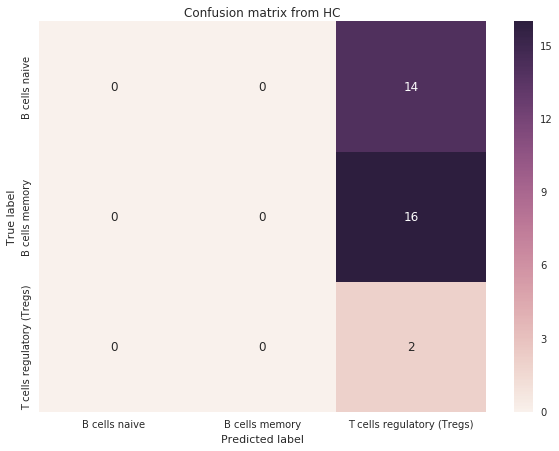

In [38]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test_flat, ypred_blended),
                     index = flat_classes_map.values(),
                     columns = flat_classes_map.values()
                    )
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,
            annot=True,
            #cmap="YlGnBu"
           )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix from HC')
savefig(plt.gcf(), 'confusion_mat_hc.png', dpi=300)

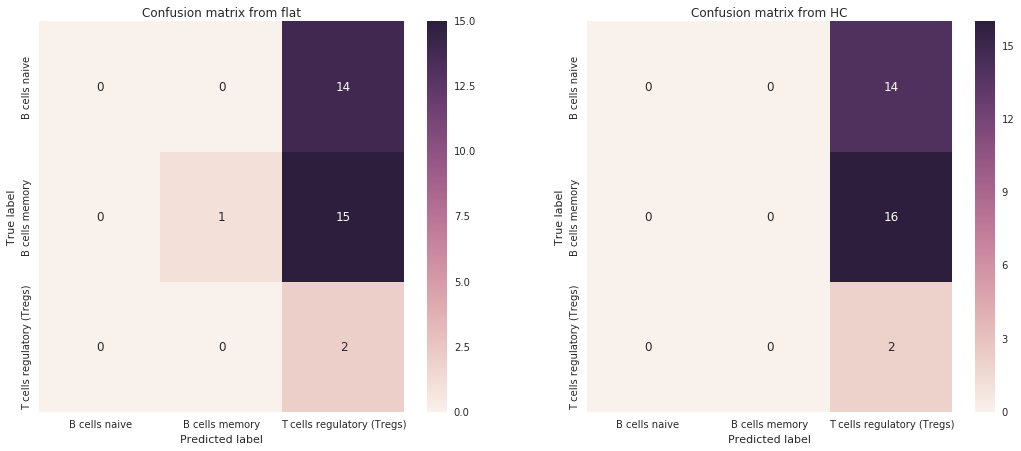

In [39]:
# plot both of them next to each other

f, [ax1, ax2] = plt.subplots(1,2, figsize = (18,7))

# flat
df_cm = pd.DataFrame(confusion_matrix(y_test_flat, y_pred),
                     index = flat_classes_map.values(),
                     columns = flat_classes_map.values()
                    )

sns.heatmap(df_cm,
            annot=True,
            ax=ax1
           )
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.set_title('Confusion matrix from flat')


# HC
df_cm = pd.DataFrame(confusion_matrix(y_test_flat, ypred_blended),
                     index = flat_classes_map.values(),
                     columns = flat_classes_map.values()
                    )

sns.heatmap(df_cm,
            annot=True,
            ax=ax2
           )
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.set_title('Confusion matrix from HC')

savefig(f, 'confusion_mat_together.png', dpi=300)

# Conclusions

* Improvement in terms of standard F1: 0.22 --> 0.5 (increase of 0.28)
* Improvement in terms of hF: 0.37 --> 0.73 (increase of 0.36)
* Note about hF and error: we don't have these kinds of errors because no partial labeling
  * Generalization error: predicted class is more generic than true known class
  * Specialization error: predicted class is more specific than true known class


# Next

What if you allow partial labeling? Like returning "B cells" if not confident enough to go to "B cells naive" vs "B cells memory"? This is the case if P(B cells) is significantly > P(B cells) * P(B cell subtype) ?

Actually read Dumais for this two-level case and just use their thresholds.

Then cross-val.

How do you evaluate? Separately evaluate test examples where could go all the way down and those where couldn't?

